# NI DAQ for SCF measurement

In [14]:
import LDAQ #custom version of LDAQ --> should be installed properly via pip
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [2]:
# Simulation was used before first test structure was created

#def simulate_signal(t, f1, f2):
#    """
#    first argument must be time.
#    If multi_processing is True, then the function must be pickable and
#    all libraries must be imported inside the function.
#    """
#    #import numpy as np
#    sig1 = np.sin(2*np.pi*f1*t) + np.random.rand(len(t))*0.3
#    sig2 = np.cos(2*np.pi*f2*t) + np.random.rand(len(t))*0.3
#    return np.array([sig1, sig2]).T
#
#fs = 1_000_000
#acq_simulated = LDAQ.simulator.SimulatedAcquisition(acquisition_name='sim')
#acq_simulated.set_simulated_data(simulate_signal, channel_names=["ch1", "ch2"], sample_rate=fs, args=(84, 120)) # use function
#acq_simulated.run_acquisition(1.0)

## Set up NI Task with proper device

In [15]:
input_task_name = "ni_input_task"
acquisition_name = input_task_name + "_acq"
#fs = 1_000_000
fs = 500_000

ni_task = LDAQ.national_instruments.NITask(input_task_name, sample_rate=fs)
ni_task

Task name: ni_input_task
Connected devices:
	(0) - cDAQ1
	(1) - cDAQ1Mod3
	(2) - cDAQ1Mod4
	(3) - SimDev1
Channels: []

In [16]:
device_name = "cDAQ1Mod3"
device_id = ni_task.device_list.index(device_name)

In [17]:
num_channels = 4

for i in range(0, num_channels):
    ni_task.add_channel(channel_name=f"ch{i+1}", device_ind=device_id, channel_ind=i, scale=1.0, units="V", min_val=-10.0, max_val=10.0)

ni_task

Task name: ni_input_task
Connected devices:
	(0) - cDAQ1
	(1) - cDAQ1Mod3
	(2) - cDAQ1Mod4
	(3) - SimDev1
Channels: ['ch1', 'ch2', 'ch3', 'ch4']

In [18]:
acq_ni = LDAQ.national_instruments.NIAcquisition(task_name=ni_task, acquisition_name=acquisition_name)
acq_ni

Acquisition name:     ni_input_task_acq
Number of channels:   0
Data channels:        []
Video channels:       []
Sample rate:          500000 Hz
Continuous mode:      False
Standalone:           True

## Set up visualization from LDAQ
Sometimes has to be run a second time after running ldaq to be set up properly. At the moment not yet sure why

In [22]:
vis = LDAQ.Visualization(refresh_rate=50)

for i in range(0, num_channels):
    vis.add_lines((i,0), source=acquisition_name, channels=i, t_span=2.0)

## Creat Core object with acquisition & visualization

In [23]:
ldaq = LDAQ.Core(acquisitions=[acq_ni], visualization=vis)
#ldaq = LDAQ.Core(acquisitions=[acq_ni])

# Set the trigger on the input task
#ldaq.set_trigger(source=acquisition_name, channel=0, level=0.025, duration=1.0, presamples=0)

ldaq

Acquisition sources (index, name):
	0 - ni_input_task_acq

Generation sources (index, name):
	None

Additional check events:
	None

Trigger settings:
	- duration [sec]      None
	- source              None
	- channel             None
	- level               None
	- presamples          None
	- type                None

In [38]:
ldaq.run(1.0)
#ldaq.run()

closing app
closing app


## Extract data from measurement dict

In [30]:
measurement = ldaq.get_measurement_dict()
data = measurement[acquisition_name]
data

{'time': array([0.00000e+00, 2.00000e-06, 4.00000e-06, ..., 9.99994e-01,
        9.99996e-01, 9.99998e-01], shape=(500000,)),
 'channel_names': ['ch1', 'ch2', 'ch3', 'ch4'],
 'data': array([[ 2.2448000e-03,  4.1185400e-03,  2.6652000e-05, -3.1373100e-03],
        [ 3.6162900e-03,  5.5018250e-03,  1.4151460e-03, -3.9178000e-04],
        [-4.9818000e-04,  6.8851100e-03, -2.7503360e-03, -1.7645450e-03],
        ...,
        [-4.9818000e-04, -3.1315000e-05, -1.5246782e-02,  3.7265150e-03],
        [ 4.9877800e-03,  1.1034965e-02, -1.1081300e-02,  3.7265150e-03],
        [-4.9818000e-04,  4.1185400e-03, -1.8023770e-02, -3.9178000e-04]],
       shape=(500000, 4)),
 'sample_rate': 500000}

In [31]:
time = data["time"]
fs = data["sample_rate"]
raw_data = data["data"]


ch1_data = raw_data[:, data["channel_names"].index("ch1")]
ch2_data = raw_data[:, data["channel_names"].index("ch2")]
ch3_data = raw_data[:, data["channel_names"].index("ch3")]
ch4_data = raw_data[:, data["channel_names"].index("ch4")]

In [39]:
ldaq.save_measurement("impact_sample_1", root="data", timestamp=True, comment="Test Comment")

'data\\20250320_135546_impact_sample_1.pkl'

In [ ]:
loaded_data = LDAQ.utils.load_measurement("20250320_135546_impact_sample_1.pkl", directory="data")
loaded_data

{'ni_input_task_acq': {'time': array([-1.00000e+00, -9.99998e-01, -9.99996e-01, ..., -6.00000e-06,
         -4.00000e-06, -2.00000e-06], shape=(500000,)),
  'channel_names': ['ch1', 'ch2', 'ch3', 'ch4'],
  'data': array([[ 3.616290e-03,  2.735255e-03,  5.580628e-03, -1.764545e-03],
         [ 8.733100e-04,  9.651680e-03,  2.665200e-05,  9.809850e-04],
         [ 3.616290e-03,  6.885110e-03,  2.665200e-05,  2.353750e-03],
         ...,
         [ 8.733100e-04,  8.268395e-03,  1.415146e-03, -3.917800e-04],
         [ 4.987780e-03,  8.268395e-03,  2.803640e-03,  5.099280e-03],
         [ 2.244800e-03,  2.735255e-03,  1.415146e-03,  2.353750e-03]],
        shape=(500000, 4)),
  'sample_rate': 500000},
 'comment': 'Test Comment'}

In [ ]:
from sdypy_sep005.sep005 import assert_sep005
from data_converter import measurement_dict_to_sep005

data_sep005 = measurement_dict_to_sep005(measurement)
assert_sep005(data_sep005)

1


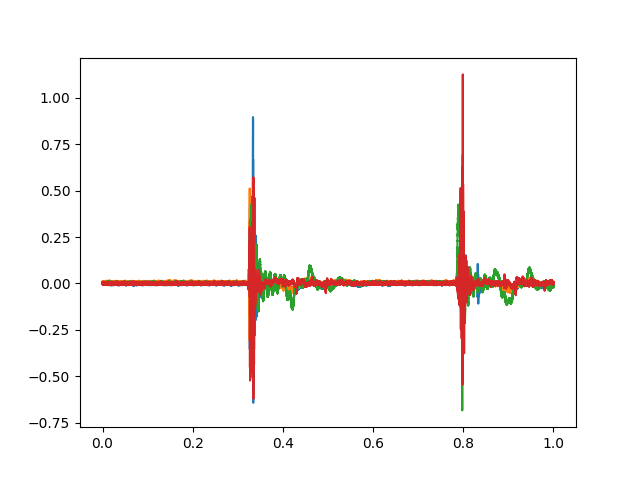

In [35]:
%matplotlib widget
plt.clf()
plt.plot(time, ch1_data, time, ch2_data, time, ch3_data, time, ch4_data)
plt.show()

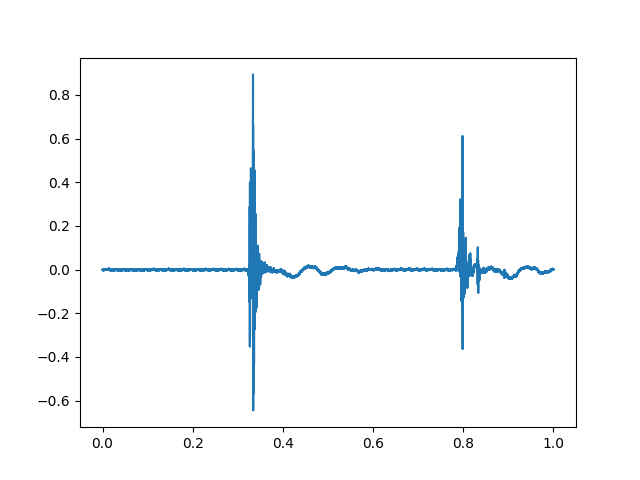

In [34]:
from scipy.signal import butter, lfilter, freqz

def butterworth_lp_filt(data, cutoff, fs, order=5):
    b, a = butter(order, cutoff, fs=fs, btype="lowpass", analog=False)
    y = lfilter(b, a, data)
    return y

f_cutoff = 25_000
ch1_data_filt = butterworth_lp_filt(ch1_data, f_cutoff, fs)

plt.clf()
plt.plot(time, ch1_data_filt)
plt.show()